# DM project: cheese

In [1]:
import os
import time
import json
import random

import pandas as pd
import plotly.express as px
import tqdm.notebook as tqdm
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
from IPython.display import display, HTML
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

In [2]:
data = pd.read_csv("cheeses.csv")
data

cheese                                        url   milk  \
0            Aarewasser         https://www.cheese.com/aarewasser/    cow   
1      Abbaye de Belloc   https://www.cheese.com/abbaye-de-belloc/  sheep   
2      Abbaye de Belval   https://www.cheese.com/abbaye-de-belval/    cow   
3     Abbaye de Citeaux  https://www.cheese.com/abbaye-de-citeaux/    cow   
4       Abbaye de Tamié              https://www.cheese.com/tamie/    cow   
...                 ...                                        ...    ...   
1182          Sveciaost          https://www.cheese.com/sveciaost/    cow   
1183               Swag               https://www.cheese.com/swag/   goat   
1184          Swaledale          https://www.cheese.com/swaledale/  sheep   
1185  Sweet Style Swiss  https://www.cheese.com/sweet-style-swiss/    NaN   
1186       Swiss cheese              https://www.cheese.com/swiss/    cow   

            country                      region        family  \
0       Switzerland                         NaN           NaN   
1            France                 Pays Basque           NaN   
2            France                         NaN           NaN   
3            France                    Burgundy           NaN   
4            France                      Savoie           NaN   
...             ...                         ...           ...   
1182         Sweden          Low-laying regions           NaN   
1183      Australia             South Australia           NaN   
1184        England  Swaledale, North Yorkshire           NaN   
1185    Switzerland                         NaN           NaN   
1186  United States                         NaN  Swiss Cheese   

                            type fat_content calcium_content  \
0                      semi-soft         NaN             NaN   
1             semi-hard, artisan         NaN             NaN   
2                      semi-hard      40-46%             NaN   
3     semi-soft, artisan, brined         NaN             NaN   
4                  soft, artisan         NaN             NaN   
...                          ...         ...             ...   
1182           semi-hard, brined         45%             NaN   
1183         fresh firm, artisan         NaN             NaN   
1184                        hard         NaN             NaN   
1185          semi-hard, artisan         NaN             NaN   
1186    hard, artisan, processed  7.8 g/100g             NaN   

                    texture        rind        color                 flavor  \
0                   buttery      washed       yellow                  sweet   
1       creamy, dense, firm     natural       yellow          burnt caramel   
2                   elastic      washed        ivory                    NaN   
3     creamy, dense, smooth      washed        white  acidic, milky, smooth   
4      creamy, open, smooth      washed        white          fruity, nutty   
...                     ...         ...          ...                    ...   
1182         creamy, supple    rindless  pale yellow                 acidic   
1183        creamy, crumbly  ash coated        white         acidic, creamy   
1184              semi firm         NaN       yellow          smooth, sweet   
1185           firm, supple       waxed          NaN                  nutty   
1186                   firm    rindless  pale yellow           nutty, sweet   

                  aroma vegetarian  vegan                     synonyms  \
0               buttery      False  False                          NaN   
1              lanoline       True  False  Abbaye Notre-Dame de Belloc   
2              aromatic      False  False                          NaN   
3     barnyardy, earthy      False  False                          NaN   
4     perfumed, pungent      False  False                          NaN   
...                 ...        ...    ...                          ...   
1182                NaN      False  False                          NaN   
1

## Cleaning and pre-processing

In [3]:
print(set(data["color"]))
data[pd.isnull(data["color"])]

{'blue-grey', 'white', 'golden yellow', 'green', 'pale white', 'cream', 'orange', 'yellow', 'pale yellow', 'golden orange', 'brownish yellow', 'red', 'pink and white', 'brown', 'straw', 'blue', 'ivory', nan}


cheese                                        url  \
10             Acapella           https://www.cheese.com/acapella/   
13                Acorn              https://www.cheese.com/acorn/   
19        Afuega'l Pitu       https://www.cheese.com/afuegal-pitu/   
48      Alpe di Frabosa    https://www.cheese.com/alpe-di-frabosa/   
50            Alpicrème          https://www.cheese.com/alpicreme/   
...                 ...                                        ...   
1172     Strathdon Blue     https://www.cheese.com/strathdon-blue/   
1175      String Cheese             https://www.cheese.com/string/   
1177            Sulguni            https://www.cheese.com/sulguni/   
1181    Sussex Slipcote    https://www.cheese.com/sussex-slipcote/   
1185  Sweet Style Swiss  https://www.cheese.com/sweet-style-swiss/   

              milk         country              region family  \
10            goat   United States          California    NaN   
13           sheep  United Kingdom            Bethania    NaN   
19             cow           Spain            Asturias    NaN   
48             cow           Italy                 NaN    NaN   
50            goat          France                 NaN    NaN   
...            ...             ...                 ...    ...   
1172           cow        Scotland                Tain   Blue   
1175           NaN             NaN                 NaN    NaN   
1177  buffalo, cow         Georgia  Svaneti, Samegrelo    NaN   
1181         sheep         England                 NaN    NaN   
1185           NaN     Switzerland                 NaN    NaN   

                    type fat_content calcium_content               texture  \
10    soft, soft-ripened         NaN             NaN                   NaN   
13         hard, artisan         52%             NaN         crumbly, firm   
19         soft, artisan         NaN             NaN                smooth   
48             semi-soft         NaN             NaN                   NaN   
50                  soft         NaN             NaN                   NaN   
...                  ...         ...             ...                   ...   
1172           semi-soft         NaN             NaN                creamy   
1175           semi-hard         NaN             NaN  chewy, firm, stringy   
1177           semi-firm         NaN             NaN        dense, elastic   
1181                soft         NaN             NaN                   NaN   
1185  semi-hard, artisan         NaN             NaN          firm, supple   

               rind color                              flavor  \
10              NaN   NaN                             buttery   
13              NaN   NaN  burnt caramel, citrusy, herbaceous   
19    cloth wrapped   NaN                       spicy, strong   
48              NaN   NaN                              bitter   
50              NaN   NaN                                 NaN   
...             ...   ...                                 ...   
1172            NaN   NaN                       creamy, spicy   
1175            NaN   NaN                                 NaN   
1177            NaN   NaN                salty, smokey , sour   
1181            NaN   NaN                               sharp   
1185          waxed   NaN                               nutty   

                aroma vegetarian  vegan                synonyms  \
10      fresh, herbal      False  False                     NaN   
13             fruity       True  False                     NaN   
19                NaN      False  False                     NaN   
48    milky, mushroom      False  False                     NaN   
50                NaN      False  False                     NaN   
...               ...        ...    ...                     ...   
1172   aromatic, rich       True  False                     NaN   
1175              NaN        NaN    NaN                     NaN   
1177              NaN        NaN    NaN  Georgian Pickle Cheese   
1181   

In [4]:
print(len(data[pd.isnull(data["calcium_content"])]))
print(len(data[pd.isnull(data["fat_content"])]))

1162
939


In [5]:
unused_columns = ["alt_spellings", "producers", "calcium_content", "url", "fat_content", "synonyms"]
for col in unused_columns:
    if col in data.columns:
        del data[col]

In [6]:
data

cheese   milk        country                      region  \
0            Aarewasser    cow    Switzerland                         NaN   
1      Abbaye de Belloc  sheep         France                 Pays Basque   
2      Abbaye de Belval    cow         France                         NaN   
3     Abbaye de Citeaux    cow         France                    Burgundy   
4       Abbaye de Tamié    cow         France                      Savoie   
...                 ...    ...            ...                         ...   
1182          Sveciaost    cow         Sweden          Low-laying regions   
1183               Swag   goat      Australia             South Australia   
1184          Swaledale  sheep        England  Swaledale, North Yorkshire   
1185  Sweet Style Swiss    NaN    Switzerland                         NaN   
1186       Swiss cheese    cow  United States                         NaN   

            family                        type                texture  \
0              NaN                   semi-soft                buttery   
1              NaN          semi-hard, artisan    creamy, dense, firm   
2              NaN                   semi-hard                elastic   
3              NaN  semi-soft, artisan, brined  creamy, dense, smooth   
4              NaN               soft, artisan   creamy, open, smooth   
...            ...                         ...                    ...   
1182           NaN           semi-hard, brined         creamy, supple   
1183           NaN         fresh firm, artisan        creamy, crumbly   
1184           NaN                        hard              semi firm   
1185           NaN          semi-hard, artisan           firm, supple   
1186  Swiss Cheese    hard, artisan, processed                   firm   

            rind        color                 flavor              aroma  \
0         washed       yellow                  sweet            buttery   
1        natural       yellow          burnt caramel           lanoline   
2         washed        ivory                    NaN           aromatic   
3         washed        white  acidic, milky, smooth  barnyardy, earthy   
4         washed        white          fruity, nutty  perfumed, pungent   
...          ...          ...                    ...                ...   
1182    rindless  pale yellow                 acidic                NaN   
1183  ash coated        white         acidic, creamy              fresh   
1184         NaN       yellow          smooth, sweet             floral   
1185       waxed          NaN                  nutty       nutty, sweet   
1186    rindless  pale yellow           nutty, sweet                NaN   

     vegetarian  vegan  
0         False  False  
1          True  False  
2         False  False  
3         False  False  
4         False  False  
...         ...    ...  
1182      False  False  
1183       True  False  
1184       True  False  
1185      False  False  
1186       True  False  

[1187 rows x 13 columns]

In [7]:
data=data.dropna(subset=["country","region"], how="all")
data=data.fillna(value={"country":""})
data=data.fillna(value={"region":""})
print(f"{len(data)} rows remaining")

1181 rows remaining


We removed 6 rows for which we could not find a suitable location. 

In [8]:
data

cheese   milk        country                      region  \
0            Aarewasser    cow    Switzerland                               
1      Abbaye de Belloc  sheep         France                 Pays Basque   
2      Abbaye de Belval    cow         France                               
3     Abbaye de Citeaux    cow         France                    Burgundy   
4       Abbaye de Tamié    cow         France                      Savoie   
...                 ...    ...            ...                         ...   
1182          Sveciaost    cow         Sweden          Low-laying regions   
1183               Swag   goat      Australia             South Australia   
1184          Swaledale  sheep        England  Swaledale, North Yorkshire   
1185  Sweet Style Swiss    NaN    Switzerland                               
1186       Swiss cheese    cow  United States                               

            family                        type                texture  \
0              NaN                   semi-soft                buttery   
1              NaN          semi-hard, artisan    creamy, dense, firm   
2              NaN                   semi-hard                elastic   
3              NaN  semi-soft, artisan, brined  creamy, dense, smooth   
4              NaN               soft, artisan   creamy, open, smooth   
...            ...                         ...                    ...   
1182           NaN           semi-hard, brined         creamy, supple   
1183           NaN         fresh firm, artisan        creamy, crumbly   
1184           NaN                        hard              semi firm   
1185           NaN          semi-hard, artisan           firm, supple   
1186  Swiss Cheese    hard, artisan, processed                   firm   

            rind        color                 flavor              aroma  \
0         washed       yellow                  sweet            buttery   
1        natural       yellow          burnt caramel           lanoline   
2         washed        ivory                    NaN           aromatic   
3         washed        white  acidic, milky, smooth  barnyardy, earthy   
4         washed        white          fruity, nutty  perfumed, pungent   
...          ...          ...                    ...                ...   
1182    rindless  pale yellow                 acidic                NaN   
1183  ash coated        white         acidic, creamy              fresh   
1184         NaN       yellow          smooth, sweet             floral   
1185       waxed          NaN                  nutty       nutty, sweet   
1186    rindless  pale yellow           nutty, sweet                NaN   

     vegetarian  vegan  
0         False  False  
1          True  False  
2         False  False  
3         False  False  
4         False  False  
...         ...    ...  
1182      False  False  
1183       True  False  
1184       True  False  
1185      False  False  
1186       True  False  

[1181 rows x 13 columns]

In [9]:
data.loc[data.country.str.contains("England, Great Britain, United Kingdom")|data.country.str.contains("England, United Kingdom"),"country"]="England"
data.loc[data.country.str.contains("Scotland"),"country"]="Scotland"
data.loc[data.country.str.contains("Great Britain, United Kingdom, Wales")|data.country.str.contains("United Kingdom, Wales"),"country"]="Wales"

In [10]:
data=data.drop(index=data[data["country"].str.contains(",")].index)
data=data.drop(index=data[data["country"].str.contains(" and ")].index)
data.reset_index()

index             cheese   milk        country  \
0         0         Aarewasser    cow    Switzerland   
1         1   Abbaye de Belloc  sheep         France   
2         2   Abbaye de Belval    cow         France   
3         3  Abbaye de Citeaux    cow         France   
4         4    Abbaye de Tamié    cow         France   
...     ...                ...    ...            ...   
1135   1182          Sveciaost    cow         Sweden   
1136   1183               Swag   goat      Australia   
1137   1184          Swaledale  sheep        England   
1138   1185  Sweet Style Swiss    NaN    Switzerland   
1139   1186       Swiss cheese    cow  United States   

                          region        family                        type  \
0                                          NaN                   semi-soft   
1                    Pays Basque           NaN          semi-hard, artisan   
2                                          NaN                   semi-hard   
3                       Burgundy           NaN  semi-soft, artisan, brined   
4                         Savoie           NaN               soft, artisan   
...                          ...           ...                         ...   
1135          Low-laying regions           NaN           semi-hard, brined   
1136             South Australia           NaN         fresh firm, artisan   
1137  Swaledale, North Yorkshire           NaN                        hard   
1138                                       NaN          semi-hard, artisan   
1139                              Swiss Cheese    hard, artisan, processed   

                    texture        rind        color                 flavor  \
0                   buttery      washed       yellow                  sweet   
1       creamy, dense, firm     natural       yellow          burnt caramel   
2                   elastic      washed        ivory                    NaN   
3     creamy, dense, smooth      washed        white  acidic, milky, smooth   
4      creamy, open, smooth      washed        white          fruity, nutty   
...                     ...         ...          ...                    ...   
1135         creamy, supple    rindless  pale yellow                 acidic   
1136        creamy, crumbly  ash coated        white         acidic, creamy   
1137              semi firm         NaN       yellow          smooth, sweet   
1138           firm, supple       waxed          NaN                  nutty   
1139                   firm    rindless  pale yellow           nutty, sweet   

                  aroma vegetarian  vegan  
0               buttery      False  False  
1              lanoline       True  False  
2              aromatic      False  False  
3     barnyardy, earthy      False  False  
4     perfumed, pungent      False  False  
...                 ...        ...    ...  
1135                NaN      False  False  
1136              fresh       True  False  
1137             floral       True  False  
1138       nutty, sweet      False  False  
1139                NaN       True  False  

[1140 rows x 14 columns]

We removed 41 cheeses because they can come froms several countries. 

In [11]:
data["location"]=data["region"]+", "+data["country"]

In [12]:
data

cheese   milk        country                      region  \
0            Aarewasser    cow    Switzerland                               
1      Abbaye de Belloc  sheep         France                 Pays Basque   
2      Abbaye de Belval    cow         France                               
3     Abbaye de Citeaux    cow         France                    Burgundy   
4       Abbaye de Tamié    cow         France                      Savoie   
...                 ...    ...            ...                         ...   
1182          Sveciaost    cow         Sweden          Low-laying regions   
1183               Swag   goat      Australia             South Australia   
1184          Swaledale  sheep        England  Swaledale, North Yorkshire   
1185  Sweet Style Swiss    NaN    Switzerland                               
1186       Swiss cheese    cow  United States                               

            family                        type                texture  \
0              NaN                   semi-soft                buttery   
1              NaN          semi-hard, artisan    creamy, dense, firm   
2              NaN                   semi-hard                elastic   
3              NaN  semi-soft, artisan, brined  creamy, dense, smooth   
4              NaN               soft, artisan   creamy, open, smooth   
...            ...                         ...                    ...   
1182           NaN           semi-hard, brined         creamy, supple   
1183           NaN         fresh firm, artisan        creamy, crumbly   
1184           NaN                        hard              semi firm   
1185           NaN          semi-hard, artisan           firm, supple   
1186  Swiss Cheese    hard, artisan, processed                   firm   

            rind        color                 flavor              aroma  \
0         washed       yellow                  sweet            buttery   
1        natural       yellow          burnt caramel           lanoline   
2         washed        ivory                    NaN           aromatic   
3         washed        white  acidic, milky, smooth  barnyardy, earthy   
4         washed        white          fruity, nutty  perfumed, pungent   
...          ...          ...                    ...                ...   
1182    rindless  pale yellow                 acidic                NaN   
1183  ash coated        white         acidic, creamy              fresh   
1184         NaN       yellow          smooth, sweet             floral   
1185       waxed          NaN                  nutty       nutty, sweet   
1186    rindless  pale yellow           nutty, sweet                NaN   

     vegetarian  vegan                             location  
0         False  False                        , Switzerland  
1          True  False                  Pays Basque, France  
2         False  False                             , France  
3         False  False                     Burgundy, France  
4         False  False                       Savoie, France  
...         ...    ...                                  ...  
1182      False  False           Low-laying regions, Sweden  
1183       True  False           South Australia, Australia  
1184       True  False  Swaledale, North Yorkshire, England  
1185      False  False                        , Switzerland  
1186       True  False                      , United States  

[1140 rows x 14 columns]

In [13]:
locs=set(data["location"])

In [14]:
def str_to_gps(loc):
    l=loc.split(",")
    loc=",".join([l[0],l[-1]])# removing details gives less errors while fetching the GPS coordinates
    try:
        res=Nominatim(user_agent="dmProject").geocode(loc) 
        return (res.latitude, res.longitude)
    except AttributeError:
        loc=l[-1]
        res=Nominatim(user_agent="dmProject").geocode(loc) 
        return (res.latitude, res.longitude)

In [15]:
def get_locations(backup_file):
    errors=set()
    if os.path.isfile(backup_file):
        with open(backup_file) as f:
            return json.load(f)
            
    locations_to_gps={}
    for loc in tqdm.tqdm(locs):
        time.sleep(1) # We don't want to overload the Nominatim server which will stop responding
        try:
            locations_to_gps[loc] = str_to_gps(loc)
            print(loc, locations_to_gps[loc])
        except AttributeError:
            errors.add(loc)
            print(loc, file=sys.stderr)
    with open(backup_file, "w") as f:
        json.dump(locations_to_gps, f)
    return locations_to_gps

In [16]:
locations_to_gps = get_locations("locations_to_gps.json")
locations_to_gps

{'Galax, Virginia, United States': [36.6612387, -80.9239671],
 'Northeastern Brazil, Brazil': [-10.3333333, -53.2],
 'Tieton, Washington, United States': [46.7020686, -120.75535],
 'Central Balkan Mountains, Bulgaria': [42.6073975, 25.4856617],
 'Postel, Belgium': [51.2874865, 5.1897863],
 ', Netherlands': [52.2434979, 5.6343227],
 'Äänekoski, Finland': [62.6032186, 25.7301361],
 'New Hampshire, United States': [43.4849133, -71.6553992],
 'Friuli Venezia Giulia and Veneto, Italy': [42.6384261, 12.674297],
 'County Cavan, Ireland': [54.03497495, -7.2937022825583675],
 'Charentes-Poitou, France': [45.4039367, 0.3756199],
 'Veneto, ': [45.6476663, 11.8665254],
 'Lazio, Sardinia, Italy': [41.9808038, 12.7662312],
 'Fairview, United States': [40.6333724, -90.1637318],
 'County Wexford, Ireland': [52.46018745, -6.606515459159162],
 'Southwestern Wisconsin, United States': [42.53116075, -90.43762550236468],
 'Co. Carlow, Ireland': [52.69078865, -6.825145150844913],
 'West Pawlet, VT, United S

In [17]:
latitudes, longitudes = [], []
for i, value in enumerate(data.location):
    latitudes.append(locations_to_gps[value][0])
    longitudes.append(locations_to_gps[value][1])
data["latitude"] = latitudes
data["longitude"] = longitudes

In [18]:
data

cheese   milk        country                      region  \
0            Aarewasser    cow    Switzerland                               
1      Abbaye de Belloc  sheep         France                 Pays Basque   
2      Abbaye de Belval    cow         France                               
3     Abbaye de Citeaux    cow         France                    Burgundy   
4       Abbaye de Tamié    cow         France                      Savoie   
...                 ...    ...            ...                         ...   
1182          Sveciaost    cow         Sweden          Low-laying regions   
1183               Swag   goat      Australia             South Australia   
1184          Swaledale  sheep        England  Swaledale, North Yorkshire   
1185  Sweet Style Swiss    NaN    Switzerland                               
1186       Swiss cheese    cow  United States                               

            family                        type                texture  \
0              NaN                   semi-soft                buttery   
1              NaN          semi-hard, artisan    creamy, dense, firm   
2              NaN                   semi-hard                elastic   
3              NaN  semi-soft, artisan, brined  creamy, dense, smooth   
4              NaN               soft, artisan   creamy, open, smooth   
...            ...                         ...                    ...   
1182           NaN           semi-hard, brined         creamy, supple   
1183           NaN         fresh firm, artisan        creamy, crumbly   
1184           NaN                        hard              semi firm   
1185           NaN          semi-hard, artisan           firm, supple   
1186  Swiss Cheese    hard, artisan, processed                   firm   

            rind        color                 flavor              aroma  \
0         washed       yellow                  sweet            buttery   
1        natural       yellow          burnt caramel           lanoline   
2         washed        ivory                    NaN           aromatic   
3         washed        white  acidic, milky, smooth  barnyardy, earthy   
4         washed        white          fruity, nutty  perfumed, pungent   
...          ...          ...                    ...                ...   
1182    rindless  pale yellow                 acidic                NaN   
1183  ash coated        white         acidic, creamy              fresh   
1184         NaN       yellow          smooth, sweet             floral   
1185       waxed          NaN                  nutty       nutty, sweet   
1186    rindless  pale yellow           nutty, sweet                NaN   

     vegetarian  vegan                             location   latitude  \
0         False  False                        , Switzerland  46.798562   
1          True  False                  Pays Basque, France  47.686790   
2         False  False                             , France  46.603354   
3         False  False                     Burgundy, France  47.278087   
4         False  False                       Savoie, France  45.494895   
...         ...    ...                                  ...        ...   
1182      False  False           Low-laying regions, Sweden  59.674971   
1183       True  False           South Australia, Australia -30.534367   
1184       True  False  Swaledale, North Yorkshire, England  54.382993   
1185      False  False                        , Switzerland  46.798562   
1186       True  False                      , United States  39.783730   

       longitude  
0       8.231974  
1       7.392763  
2       1.888334  
3       4.222486  
4       6.384660  
...          ...  
1182   14.520858  
1183  135.630121  
1184   -1.984136  
1185    8.231974  
1186 -100.445882  

[1140 rows x 16 columns]

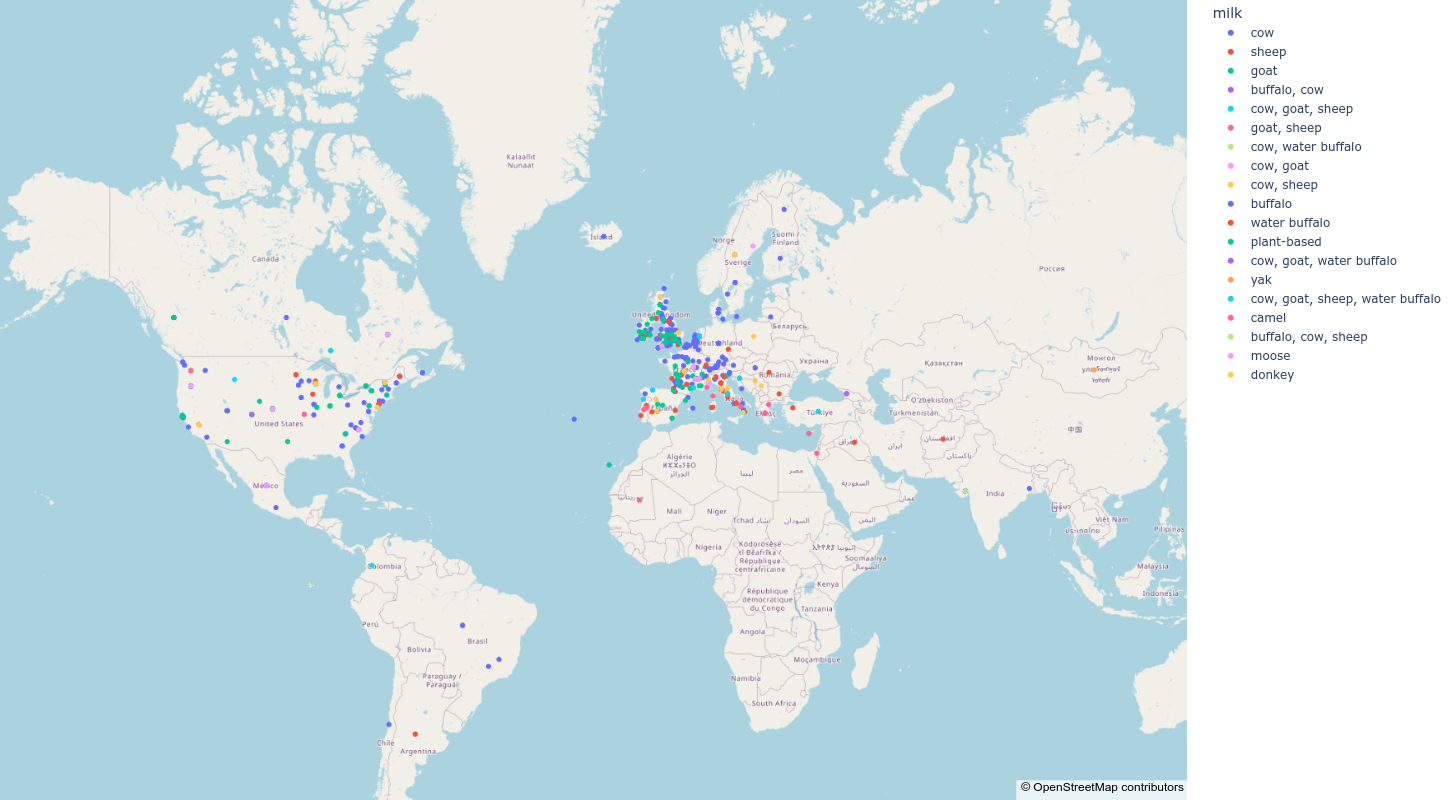

In [19]:
fig = px.scatter_mapbox(data, 
                        lat="latitude", 
                        lon="longitude", 
                        hover_name="cheese", 
                        hover_data=["cheese"],
                        color="milk",
                        zoom=1.5,
                        height=800,
                        width=1400)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [20]:
def filter_df(df, cols=None):
    if cols is None:
        cols = ["milk", 
                # "country",
                "color",
                "type", "texture", "flavor", "aroma", "family", "rind"]

    df = df.copy()
    attributes = set() # Get all the possible attributes (some are mixed in different columns)
    for col in cols:
        values = set()
        for val in set(df[col]):
            if type(val) == float: # skip NaN values
                continue
            values = values.union([x.strip() for x in set(val.split(","))])
        attributes = attributes.union(values)
    row_attrs = [set() for _ in range(len(df))]  # get the attributes specific to each row
    for col in cols:
        for i, row in enumerate(df[col]):
            if type(row) != float:
                row_attrs[i] = row_attrs[i].union([x.strip() for x in row.split(",")])
    for attr in attributes: # Add attributes rows
        df[attr] = list(attr in row_attrs[i] for i in range(len(df[col])))
        df=df.copy()
    for col in cols:
        del df[col]

    return df.copy()

In [21]:
data_features=filter_df(data)

In [22]:
data_features

cheese        country                      region vegetarian  \
0            Aarewasser    Switzerland                                  False   
1      Abbaye de Belloc         France                 Pays Basque       True   
2      Abbaye de Belval         France                                  False   
3     Abbaye de Citeaux         France                    Burgundy      False   
4       Abbaye de Tamié         France                      Savoie      False   
...                 ...            ...                         ...        ...   
1182          Sveciaost         Sweden          Low-laying regions      False   
1183               Swag      Australia             South Australia       True   
1184          Swaledale        England  Swaledale, North Yorkshire       True   
1185  Sweet Style Swiss    Switzerland                                  False   
1186       Swiss cheese  United States                                   True   

      vegan                             location   latitude   longitude  \
0     False                        , Switzerland  46.798562    8.231974   
1     False                  Pays Basque, France  47.686790    7.392763   
2     False                             , France  46.603354    1.888334   
3     False                     Burgundy, France  47.278087    4.222486   
4     False                       Savoie, France  45.494895    6.384660   
...     ...                                  ...        ...         ...   
1182  False           Low-laying regions, Sweden  59.674971   14.520858   
1183  False           South Australia, Australia -30.534367  135.630121   
1184  False  Swaledale, North Yorkshire, England  54.382993   -1.984136   
1185  False                        , Switzerland  46.798562    8.231974   
1186  False                      , United States  39.783730 -100.445882   

       rich  citrusy  ...  Mozzarella  fresh firm   goat   Blue  \
0     False    False  ...       False       False  False  False   
1     False    False  ...       False       False  False  False   
2     False    False  ...       False       False  False  False   
3     False    False  ...       False       False  False  False   
4     False    False  ...       False       False  False  False   
...     ...      ...  ...         ...         ...    ...    ...   
1182  False    False  ...       False       False  False  False   
1183  False    False  ...       False        True   True  False   
1184  False    False  ...       False       False  False  False   
1185  False    False  ...       False       False  False  False   
1186  False    False  ...       False       False  False  False   

      pink and white  floral  spicy   ripe  organic  tangy  
0              False   False  False  False    False  False  
1              False   False  False  False    False  False  
2              False   False  False  False    False  False  
3              False   False  False  False    False  False  
4              False   False  False  False    False  False  
...              ...     ...    ...    ...      ...    ...  
1182           False   False  False  False    False  False  
1183           False   False  False  False    False  False  
1184           False    True  False  False    False  False  
1185           False   False  False  False    False  False  
1186           False   False  False  False    False  False  

[1140 rows x 172 columns]

## Classification

In [23]:
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

Transformer:  la couleur en RGB; la localisation en GPS
1ère question: est-ce que la couleur suffit à savoir d'où ça vient ? 
2ème question: est-ce que si on ajoute le type ça marche ? 
3ème question: et les caractéristiques gustatives ?


In [24]:
data_features.drop(columns=["region"])
data_features

cheese        country                      region vegetarian  \
0            Aarewasser    Switzerland                                  False   
1      Abbaye de Belloc         France                 Pays Basque       True   
2      Abbaye de Belval         France                                  False   
3     Abbaye de Citeaux         France                    Burgundy      False   
4       Abbaye de Tamié         France                      Savoie      False   
...                 ...            ...                         ...        ...   
1182          Sveciaost         Sweden          Low-laying regions      False   
1183               Swag      Australia             South Australia       True   
1184          Swaledale        England  Swaledale, North Yorkshire       True   
1185  Sweet Style Swiss    Switzerland                                  False   
1186       Swiss cheese  United States                                   True   

      vegan                             location   latitude   longitude  \
0     False                        , Switzerland  46.798562    8.231974   
1     False                  Pays Basque, France  47.686790    7.392763   
2     False                             , France  46.603354    1.888334   
3     False                     Burgundy, France  47.278087    4.222486   
4     False                       Savoie, France  45.494895    6.384660   
...     ...                                  ...        ...         ...   
1182  False           Low-laying regions, Sweden  59.674971   14.520858   
1183  False           South Australia, Australia -30.534367  135.630121   
1184  False  Swaledale, North Yorkshire, England  54.382993   -1.984136   
1185  False                        , Switzerland  46.798562    8.231974   
1186  False                      , United States  39.783730 -100.445882   

       rich  citrusy  ...  Mozzarella  fresh firm   goat   Blue  \
0     False    False  ...       False       False  False  False   
1     False    False  ...       False       False  False  False   
2     False    False  ...       False       False  False  False   
3     False    False  ...       False       False  False  False   
4     False    False  ...       False       False  False  False   
...     ...      ...  ...         ...         ...    ...    ...   
1182  False    False  ...       False       False  False  False   
1183  False    False  ...       False        True   True  False   
1184  False    False  ...       False       False  False  False   
1185  False    False  ...       False       False  False  False   
1186  False    False  ...       False       False  False  False   

      pink and white  floral  spicy   ripe  organic  tangy  
0              False   False  False  False    False  False  
1              False   False  False  False    False  False  
2              False   False  False  False    False  False  
3              False   False  False  False    False  False  
4              False   False  False  False    False  False  
...              ...     ...    ...    ...      ...    ...  
1182           False   False  False  False    False  False  
1183           False   False  False  False    False  False  
1184           False    True  False  False    False  False  
1185           False   False  False  False    False  False  
1186           False   False  False  False    False  False  

[1140 rows x 172 columns]

In [25]:
Y=LabelEncoder().fit_transform(data_features["country"])

In [26]:
X=data_features.drop(columns=["cheese","country","region","vegetarian","location","latitude","longitude"])

In [27]:
data_train, data_test, target_train, target_test = train_test_split(
    X, Y)

In [28]:
c=tree.DecisionTreeClassifier(max_depth=4)

In [29]:
c=c.fit(data_train,target_train)

In [30]:
plt.figure(figsize=(100,150))
ax=plt.subplot()

tree.plot_tree(c,ax=ax,filled=True,feature_names=X.columns);


## Pattern Mining

In [31]:
unused_columns = {"vegetarian", "vegan", "cheese", "region", "color", "location", "latitude", "longitude", "country"}
data_features_only=data_features.drop(columns=list(unused_columns.intersection(data_features.columns)))

In [32]:
data_features_only.shape[1]

164

We have $196$ features in our data, that is very big compared to the number of rows of our data. So, we choose a min_support of $0.1$ during the apriori algorithm for pattern mining. 

In [33]:
frequent_itemsets=apriori(data_features_only,min_support=.1, use_colnames=True)
display(HTML(frequent_itemsets.to_html()))

In [34]:
display(HTML(association_rules(frequent_itemsets, min_threshold=0.5).to_html()))